In [ ]:
!pip install lazypredict
!pip install tpot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=c6ef8ea1acd8e80b5467b3637d3c2331d0f67e53c13a42df906e2b533a23d99b
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from scipy import stats
from tpot import TPOTClassifier
from sklearn.neighbors import KNeighborsClassifier
# Filter out specific warning by category
warnings.filterwarnings("ignore")
# Your code here that triggers the warning
drive.mount('/content/drive')

Mounted at /content/drive


# Data Understanding

## Data loading

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/portofolio/Classification of sloth/dataset.csv")
train_df.head()

,Unnamed: 0,claw_length_cm,endangered,size_cm,specie,sub_specie,tail_length_cm,weight_kg
0,0,6.83,critically_endangered,52.00,three_toed,Pygmy three-toed sloth,4.45,3.57
1,1,8.26,critically_endangered,50.08,three_toed,Pygmy three-toed sloth,6.29,2.84
2,2,8.66,critically_endangered,51.50,three_toed,Pygmy three-toed sloth,4.55,1.26
3,3,8.47,critically_endangered,50.12,three_toed,Pygmy three-toed sloth,6.98,2.39
4,4,7.10,critically_endangered,51.36,three_toed,Pygmy three-toed sloth,5.41,3.16


**Remove Unnamed Column**

In [ ]:
train_df.drop(["Unnamed: 0"], axis=1, inplace=True)

## Exploratory Data Analysis

### Apa saja jenis variabel pada dataset?

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   claw_length_cm  5000 non-null   float64
 1   endangered      5000 non-null   object 
 2   size_cm         5000 non-null   float64
 3   specie          5000 non-null   object 
 4   sub_specie      5000 non-null   object 
 5   tail_length_cm  5000 non-null   float64
 6   weight_kg       5000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


Data memiliki 6 feature + 1 target dengan 5000 data dan data tidak memiliki missing value

In [ ]:
numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  4
Number of Categorical features:  3


In [ ]:
train_df.describe(include="all")

,claw_length_cm,endangered,size_cm,specie,sub_specie,tail_length_cm,weight_kg
count,5000.00,5000,5000.00,5000,5000,5000.00,5000.00
unique,NaN,3,NaN,2,6,NaN,NaN
top,NaN,least_concern,NaN,three_toed,Hoffman’s two-toed sloth,NaN,NaN
freq,NaN,4390,NaN,2662,1198,NaN,NaN
mean,7.42,NaN,60.40,NaN,NaN,3.41,5.25
std,1.52,NaN,5.93,NaN,NaN,2.33,1.27
min,1.75,NaN,46.93,NaN,NaN,-2.94,0.95
25%,6.38,NaN,59.90,NaN,NaN,1.44,4.38
50%,7.45,NaN,62.48,NaN,NaN,3.81,5.27
75%,8.49,NaN,64.40,NaN,NaN,5.35,6.13


### Apakah ada missing value?

Text(0.5, 1.0, 'Count of missing value')

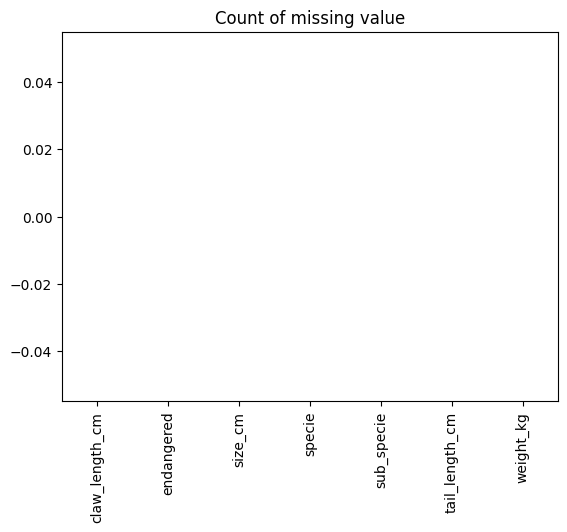

In [ ]:
train_df.isna().sum().plot(kind="bar")
plt.title("Count of missing value")

Check value terhadap claw_length_cm, size_cm, tail_length_cm, weight_kg tidak kurang dari 0

In [ ]:
sloth_invalid_data = (train_df["claw_length_cm"] <= 0) | (train_df["size_cm"] <= 0) | (train_df["tail_length_cm"] <= 0) | (train_df["weight_kg"] <= 0)

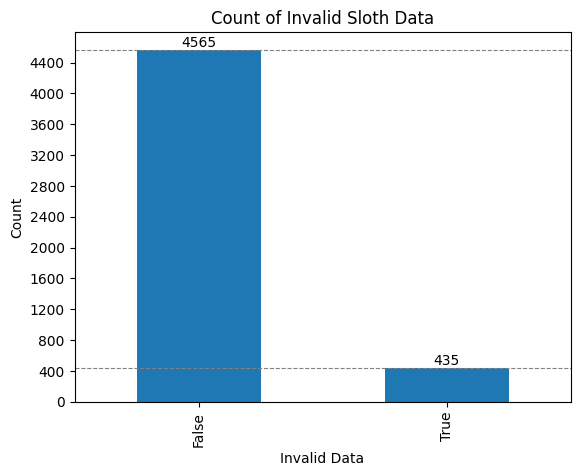

In [ ]:
# Count the occurrences of True (invalid data) and False (valid data)
invalid_counts = sloth_invalid_data.value_counts()

# Plot the counts
ax = invalid_counts.plot(kind='bar')

# Set the step value for the y-axis ticks
step = 400  # Set the step value as desired
ax.set_yticks(range(0, max(invalid_counts) + 1, step))
# Add annotations as lines like grid for the values
for index, value in invalid_counts.items():
    ax.axhline(value, color='gray', linestyle='--', linewidth=0.8)
    ax.text(index, value + 0.2, str(value), ha='center', va='bottom')
plt.xlabel('Invalid Data')
plt.ylabel('Count')
plt.title('Count of Invalid Sloth Data')
plt.show()

In [ ]:
rows_to_drop = train_df[sloth_invalid_data].index
train_df.drop(rows_to_drop, inplace=True)

### Apakah ada outlier value?

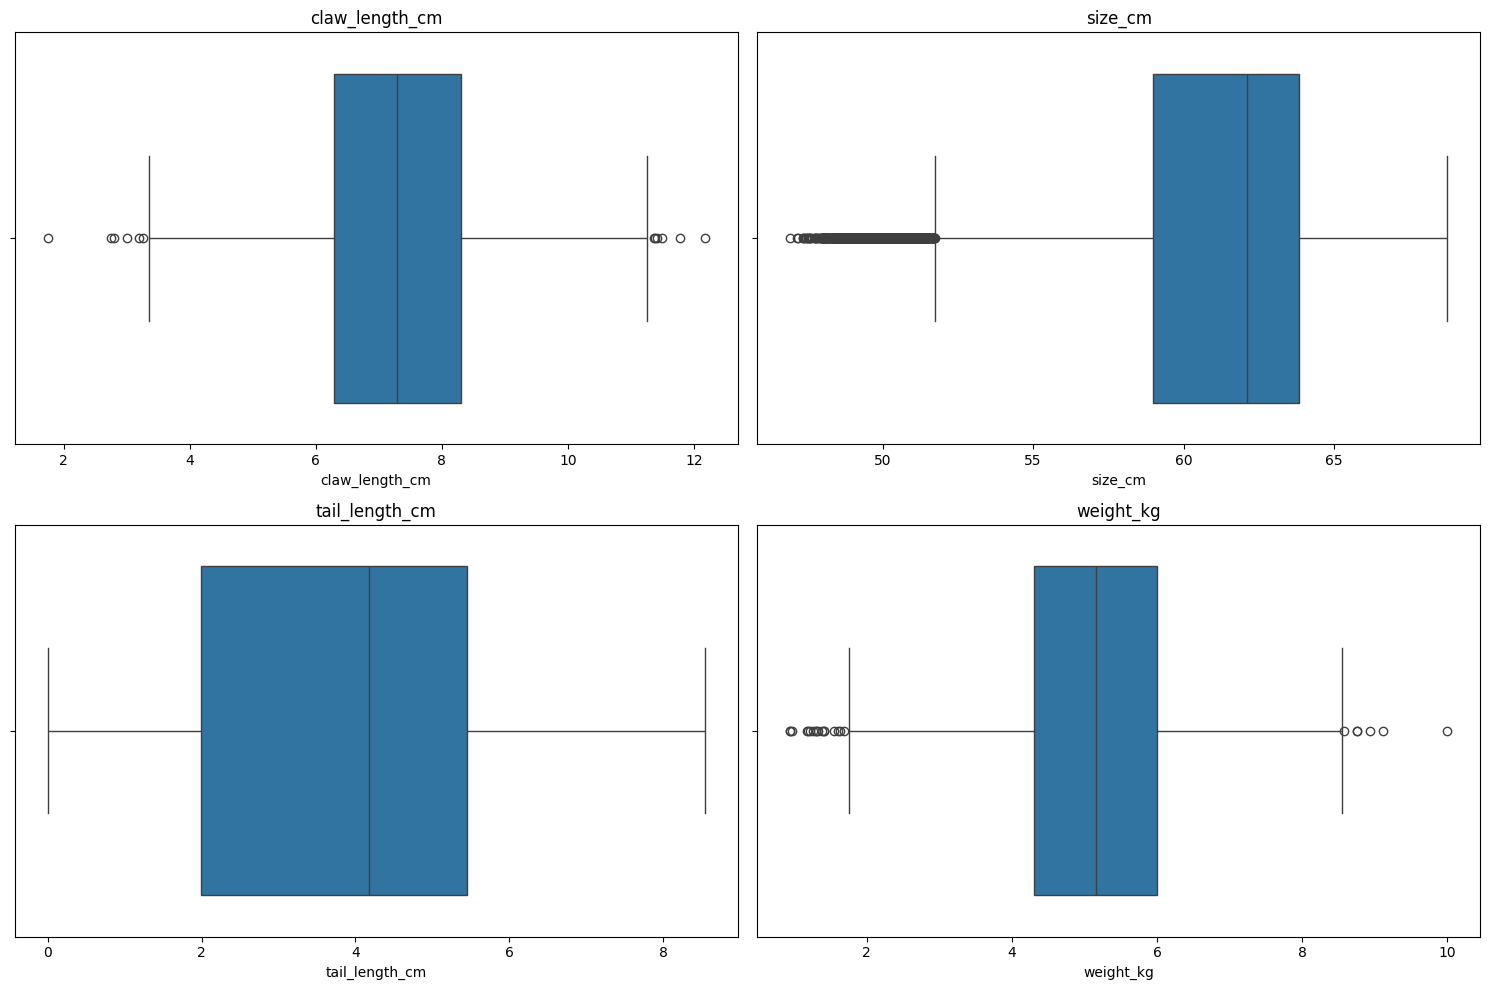

In [ ]:
count_numeric_cols = len(numerical_feats)
num_rows = (count_numeric_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(numerical_feats):
    sns.boxplot(x=train_df[col], ax=axes[index])
    axes[index].set_title(col)

# Hide any remaining empty subplots
for ax in axes[count_numeric_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_outliers(column):
  # Calculate the IQR
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1

  # Define lower and upper bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter the column to count outliers
  outliers = column[(column < lower_bound) | (column > upper_bound)]

  # Calculate percentage of outliers
  percentage_outliers = (outliers.shape[0] / column.shape[0]) * 100

  return outliers.shape[0], percentage_outliers

In [ ]:
outliers_info = []

for feature in numerical_feats:
  num_outliers, percentage_outliers = calculate_outliers(train_df[feature])

  if percentage_outliers > 0:
    outliers_info.append({
        'feature': feature,
        'outlier_count': num_outliers,
        'percentage_outliers': percentage_outliers
    })

outliers_df = pd.DataFrame(outliers_info).sort_values(by='percentage_outliers', ascending=True)
outliers_df

,feature,outlier_count,percentage_outliers
0,claw_length_cm,12,0.26
2,weight_kg,23,0.50
1,size_cm,1072,23.48


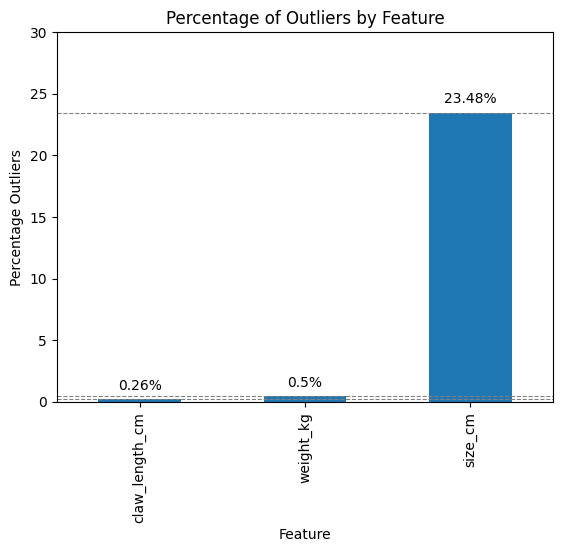

In [ ]:
ax = outliers_df[["percentage_outliers", "feature"]].set_index("feature").plot(kind="bar", legend=None)
ax.set_xlabel("Feature")
ax.set_ylabel("Percentage Outliers")
ax.set_ylim(0,30)
ax.set_title("Percentage of Outliers by Feature")
for index, value in enumerate(outliers_df["percentage_outliers"]):
    value = round(value, 2)
    ax.axhline(value, color='gray', linestyle='--', linewidth=0.8)
    ax.text(index, value + 0.5, f'{value}%', ha='center', va='bottom')

plt.show()

Fitur size_cm fitur yang memiliki jumlah outlier terbanyak yaitu diatas 10%.

In [ ]:
def remove_outliers_iqr(dataframe, column_name):
    # Calculate the IQR
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to exclude outliers
    filtered_dataframe = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]

    # Display information about the removed outliers
    outliers_removed = dataframe.shape[0] - filtered_dataframe.shape[0]
    print(f"Number of outliers removed in '{column_name}': {outliers_removed}")

    return filtered_dataframe

In [ ]:
for feature in ['size_cm']:
  train_df = remove_outliers_iqr(train_df, feature)
  train_df.reset_index(drop=True, inplace=True)

Number of outliers removed in 'size_cm': 1072


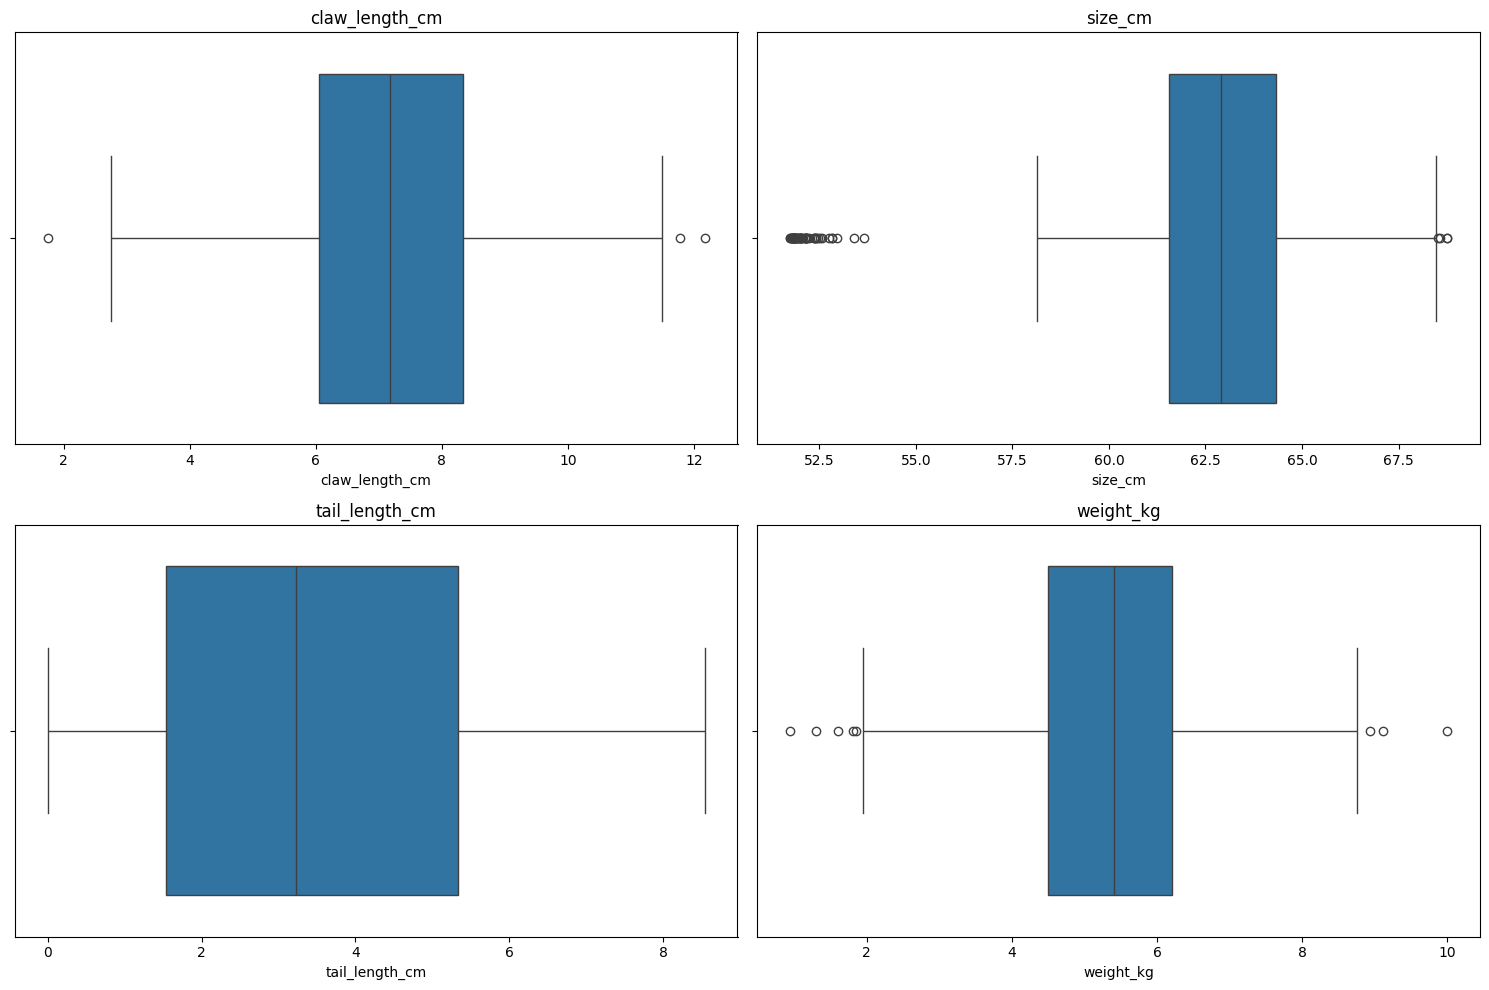

In [ ]:
count_numeric_cols = len(numerical_feats)
num_rows = (count_numeric_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(numerical_feats):
    sns.boxplot(x=train_df[col], ax=axes[index])
    axes[index].set_title(col)

# Hide any remaining empty subplots
for ax in axes[count_numeric_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Bagaimana distribusi variabel dalam dataset?

In [ ]:
train_df.describe(include="all")

,claw_length_cm,endangered,size_cm,specie,sub_specie,tail_length_cm,weight_kg
count,3493.00,3493,3493.00,3493,3493,3493.00,3493.00
unique,NaN,3,NaN,2,6,NaN,NaN
top,NaN,least_concern,NaN,two_toed,Hoffman’s two-toed sloth,NaN,NaN
freq,NaN,2952,NaN,1903,1189,NaN,NaN
mean,7.20,NaN,62.95,NaN,NaN,3.44,5.35
std,1.58,NaN,2.39,NaN,NaN,2.13,1.22
min,1.75,NaN,51.74,NaN,NaN,0.00,0.95
25%,6.05,NaN,61.57,NaN,NaN,1.54,4.50
50%,7.17,NaN,62.91,NaN,NaN,3.22,5.40
75%,8.33,NaN,64.33,NaN,NaN,5.34,6.21


In [ ]:
feature_skewness = train_df.skew()
skewed_features_df = pd.DataFrame(feature_skewness, columns=['Skewness']).sort_values('Skewness', ascending=False)
skewed_features_df

,Skewness
tail_length_cm,0.13
claw_length_cm,0.03
weight_kg,-0.07
size_cm,-1.05


In [ ]:
# def barplot comparison
def barplot_value(x, y, title):
  chart = sns.barplot(x=x, y=y, ci = None)
  chart.set_title(title)
  for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')
  plt.xticks(rotation=45, ha='right')
  return chart

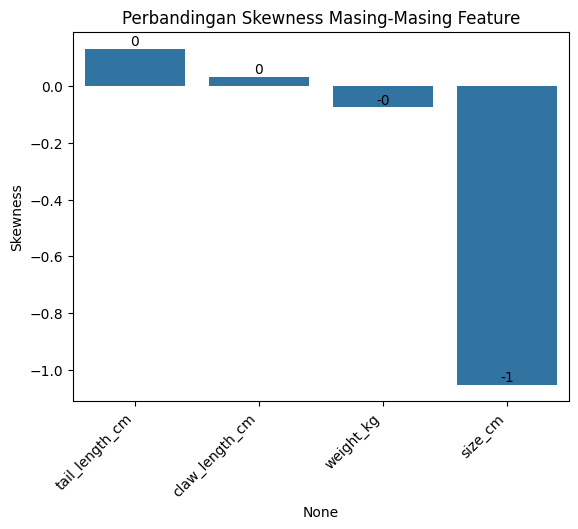

In [ ]:
barplot_value(skewed_features_df.index, skewed_features_df.Skewness, "Perbandingan Skewness Masing-Masing Feature");

**Univariate Analysis**

**Categorical Features**

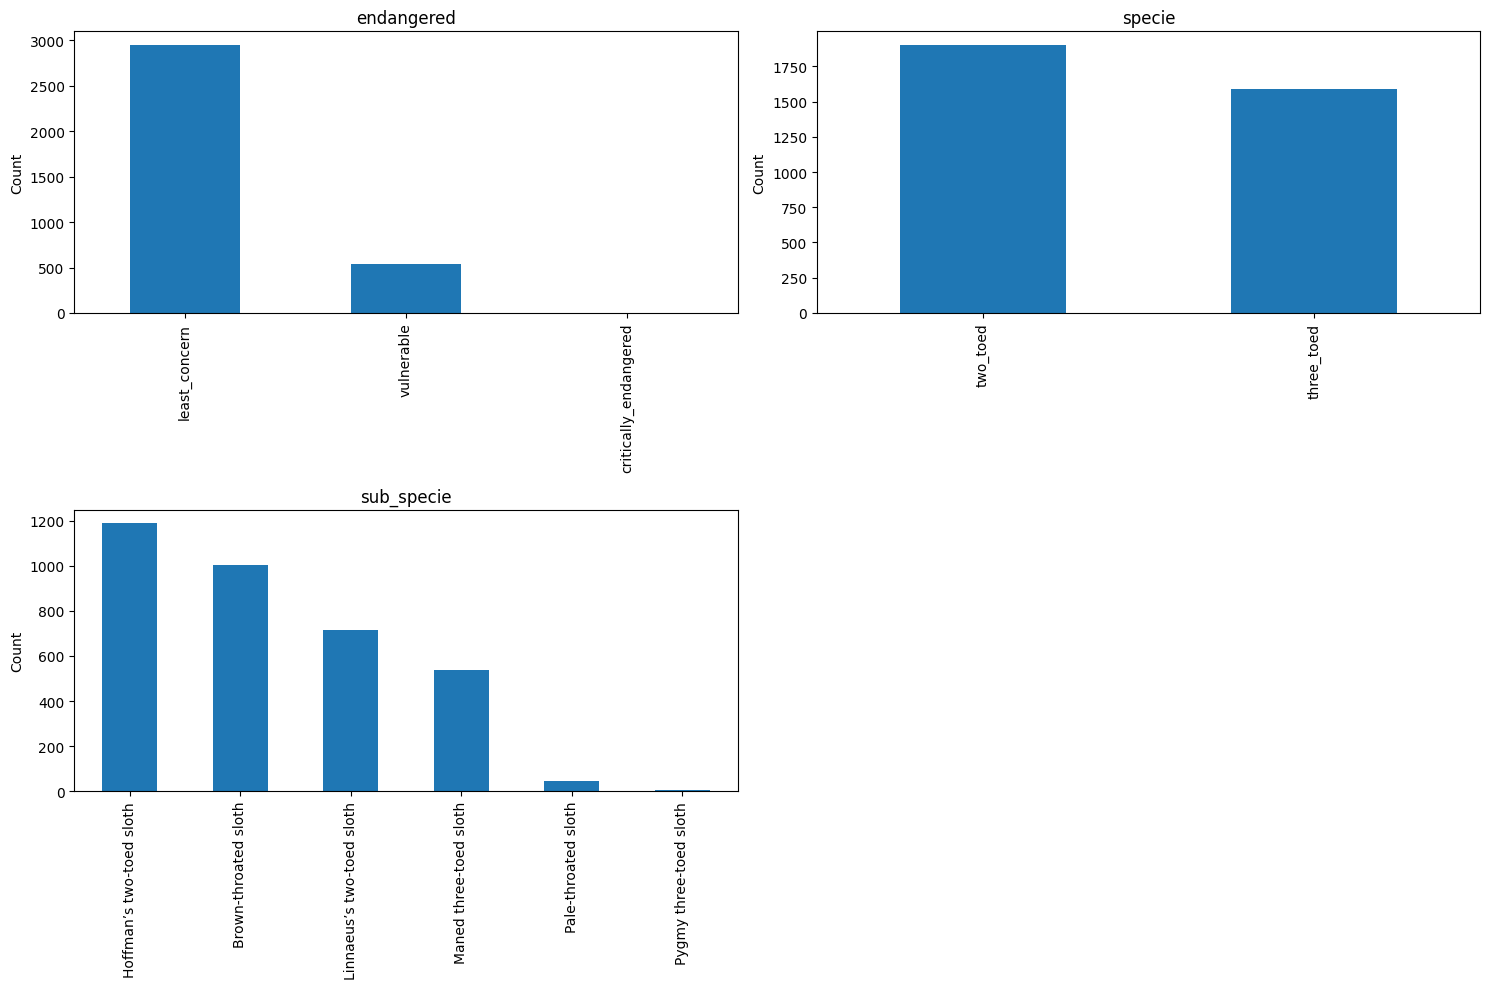

In [ ]:
count_categorical_cols = len(categorical_feats)
num_rows = (count_categorical_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(categorical_feats):
    count = train_df[col].value_counts()
    percent = 100 * train_df[col].value_counts(normalize=True).round(2)
    df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent})
    ax = axes[index]
    count.plot(kind='bar', ax=ax, title=col)
    ax.set_ylabel('Count')

# Hide any remaining empty subplots
for ax in axes[count_categorical_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Numerical Features**

In [ ]:
train_df.skew()

claw_length_cm    0.03
size_cm          -1.05
tail_length_cm    0.13
weight_kg        -0.07
dtype: float64

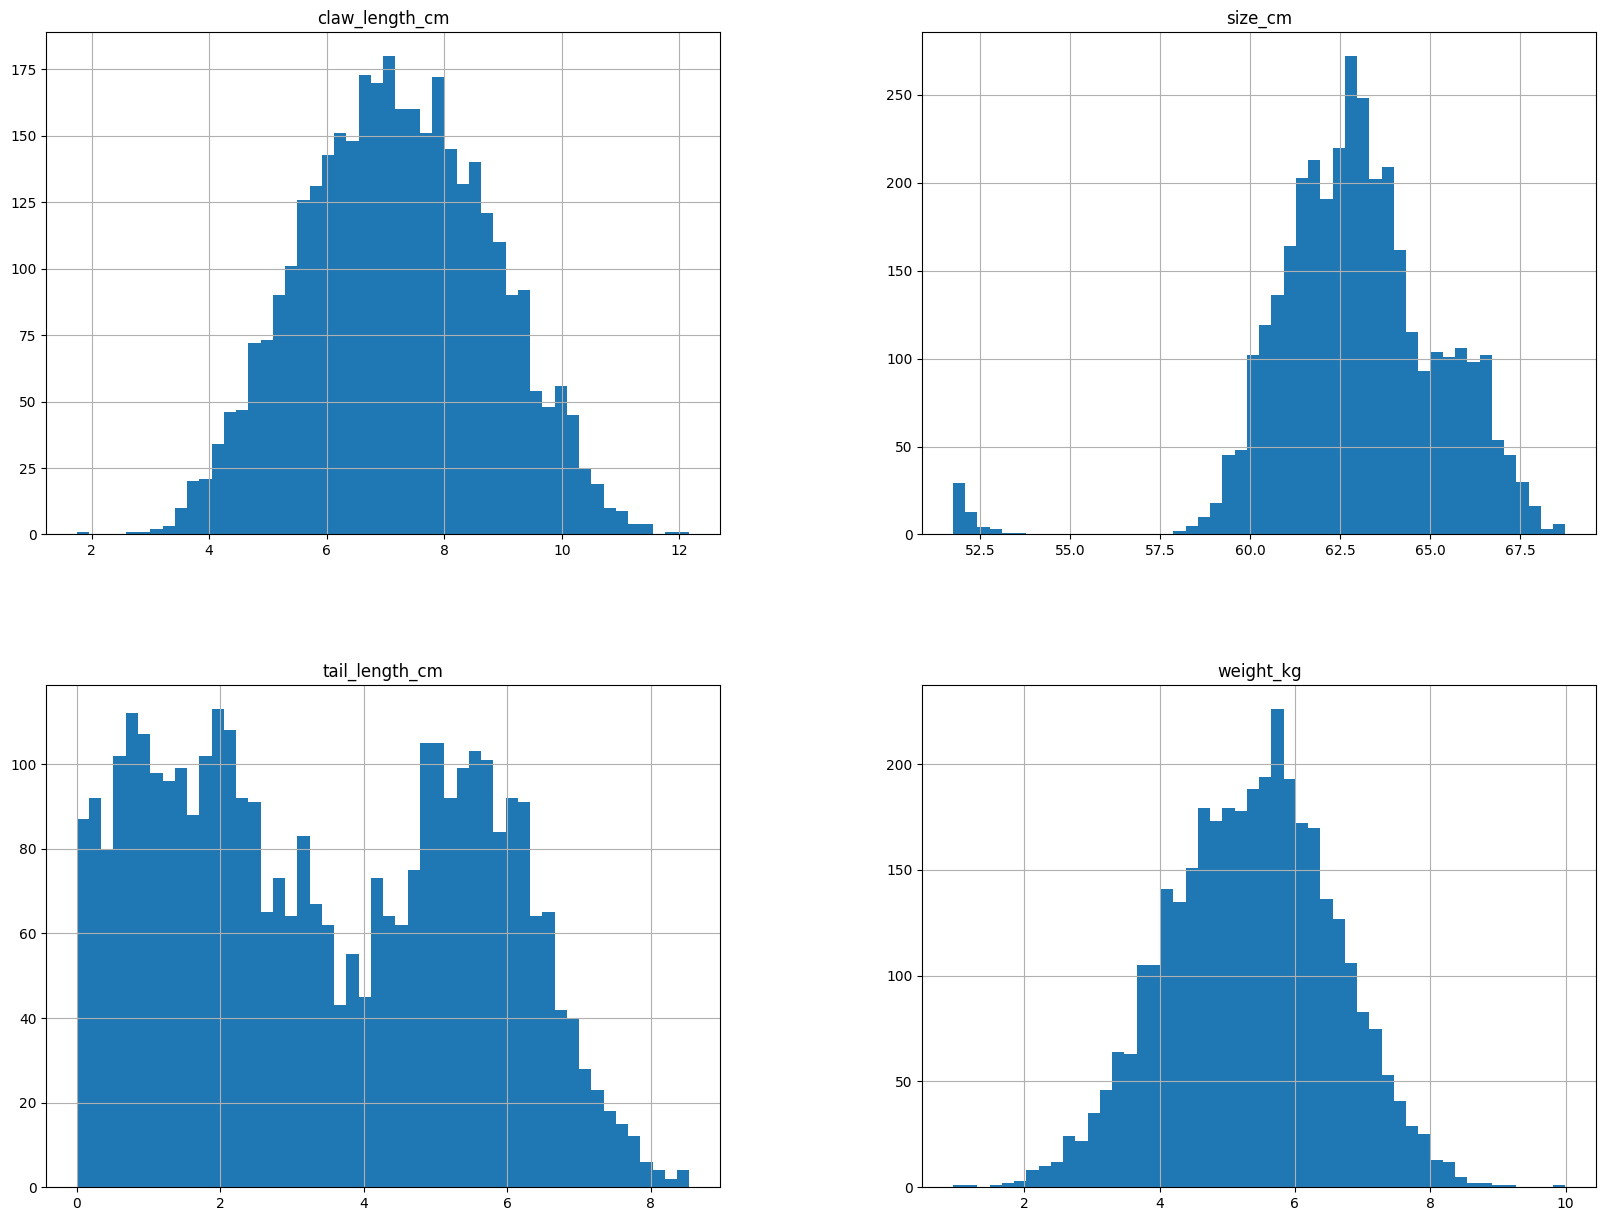

In [ ]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

**Multivariate Analysis**

**Correlation between feature**

**Categorical Feature**

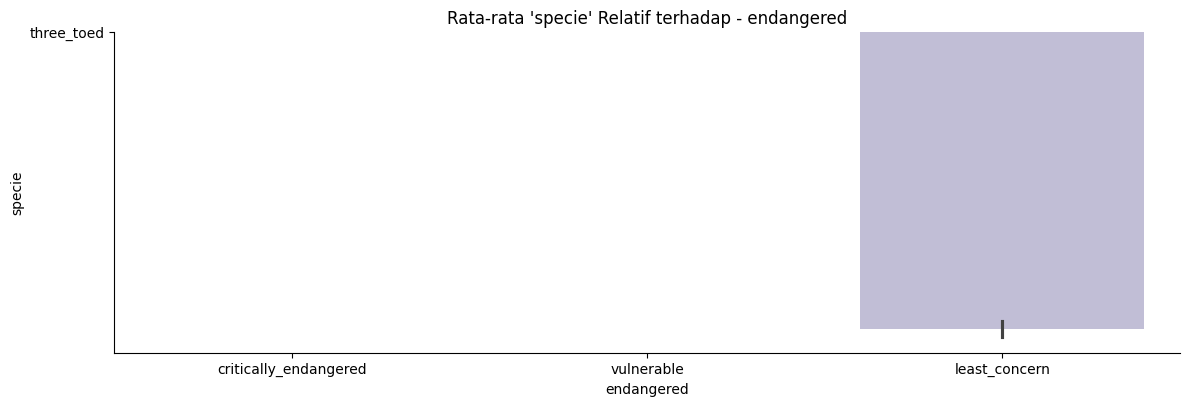

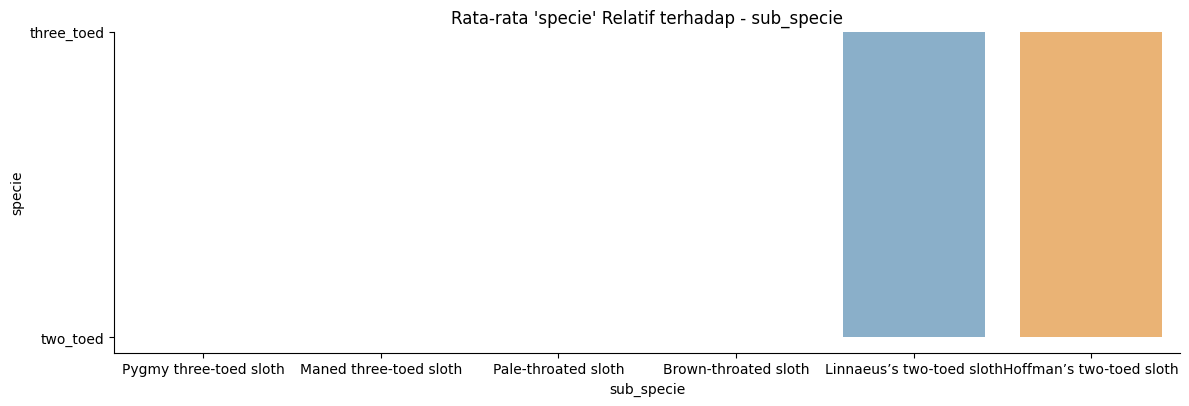

In [ ]:
for col in categorical_feats:
  if col == "specie":
    continue
  sns.catplot(x=col, y="specie", kind="bar", dodge=False, height = 4, aspect = 3,  data=train_df, palette="Set3")
  plt.title("Rata-rata 'specie' Relatif terhadap - {}".format(col))
plt.show()

Dari analisis catplot, dapat dilihat bahwa semua fitur kategorikal tidak terdistribusi secara merata. Hal ini ditandai oleh kehadiran nilai yang dominan dan tidak dominan dalam setiap kelas. maka dari itu, feature diatas akan di drop

In [ ]:
train_df.drop(["sub_specie", "endangered"], axis=1, inplace=True)

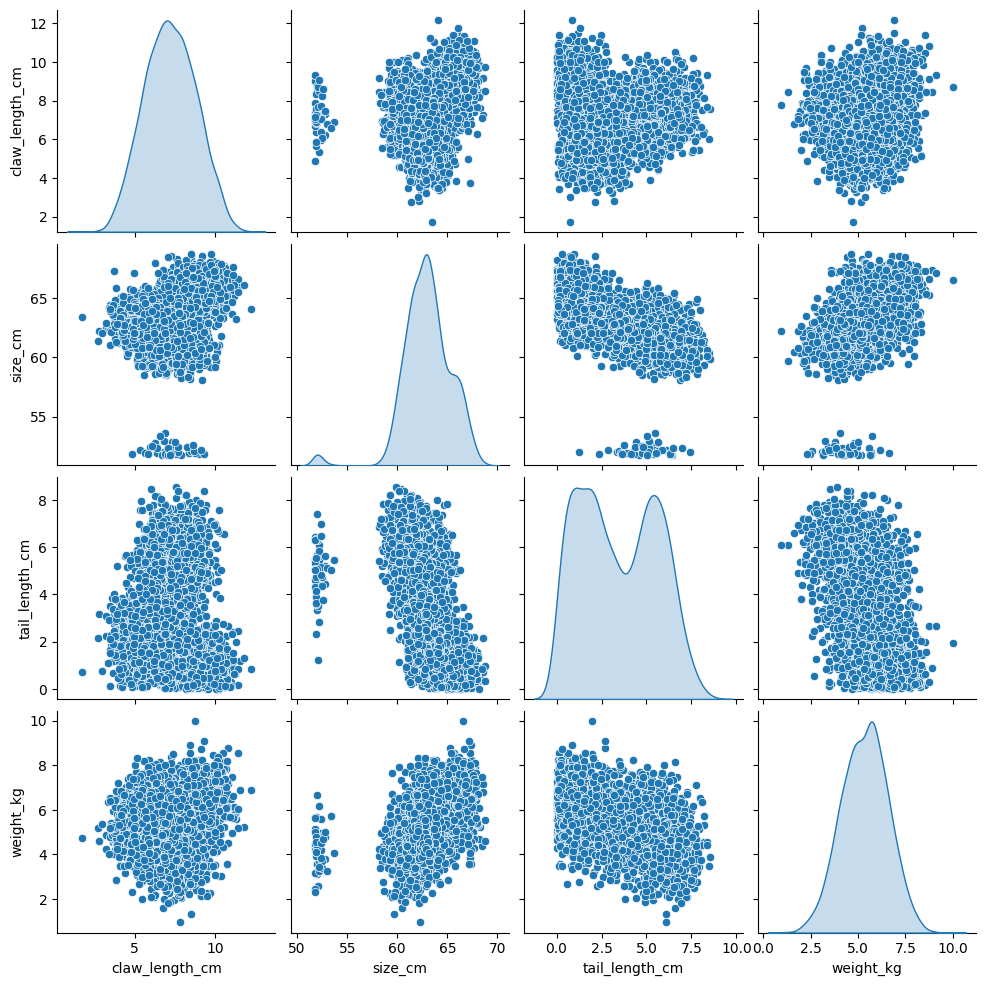

In [ ]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(train_df, diag_kind = 'kde')

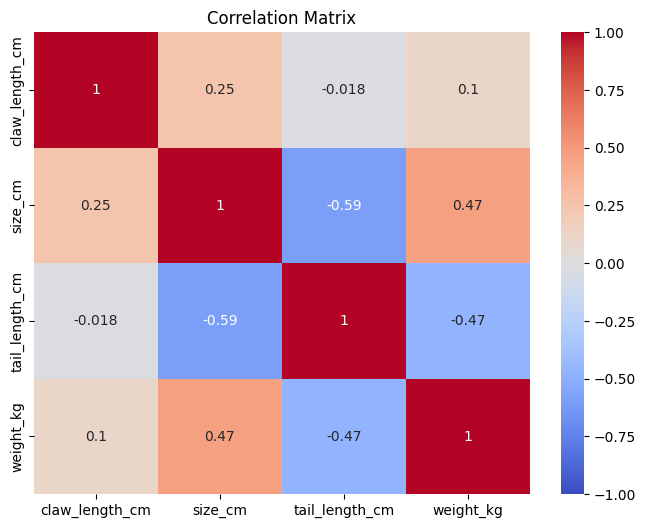

In [ ]:
# Hitung koefisien korelasi
corr_matrix = train_df.corr()

# Plot correlation matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Data Preparation

### Encoding

**Encoding categorical value into numerical**

In [ ]:
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
train_df[categorical_cols] = train_df[categorical_cols].astype('category')

In [ ]:
encoder = LabelEncoder()
train_df["specie"] = encoder.fit_transform(train_df["specie"])

In [ ]:
encoder.classes_

array(['three_toed', 'two_toed'], dtype=object)

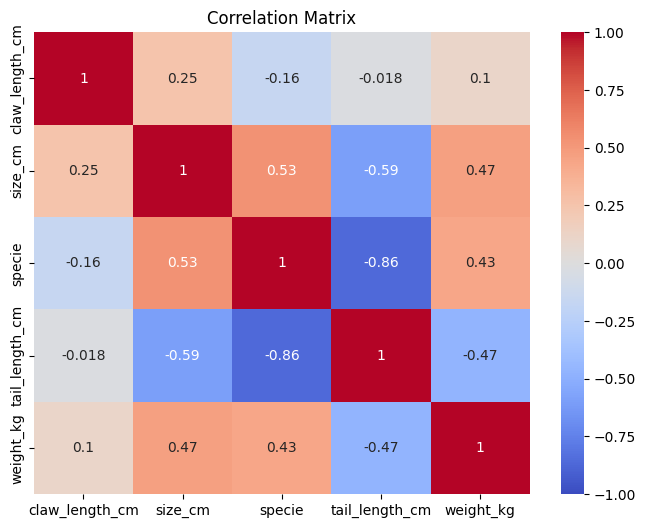

In [ ]:
# Hitung koefisien korelasi
corr_matrix = train_df.corr()

# Plot correlation matrix sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Standarisasi

In [ ]:
X = train_df.drop(["specie"],axis=1)
y = train_df["specie"]

In [ ]:
scaler = StandardScaler()
scaler.fit(X[numerical_feats])
X[numerical_feats] = scaler.transform(X.loc[:, numerical_feats])
X[numerical_feats].head()

,claw_length_cm,size_cm,tail_length_cm,weight_kg
0,-0.24,-4.59,0.48,-1.46
1,-0.06,-4.58,1.04,-1.84
2,0.80,-4.60,0.38,-1.76
3,0.85,-4.56,0.65,-2.28
4,-0.92,1.20,0.77,-0.97


### Train-Test-Split

In [ ]:
X.head()

,claw_length_cm,size_cm,tail_length_cm,weight_kg
0,-0.24,-4.59,0.48,-1.46
1,-0.06,-4.58,1.04,-1.84
2,0.80,-4.60,0.38,-1.76
3,0.85,-4.56,0.65,-2.28
4,-0.92,1.20,0.77,-0.97


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, random_state = 1)

## Model Development

### Find Optimal Model Using TPOT

In [ ]:
# # define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
model.export('tpot_sonar_best_model.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9666950986562435

Generation 2 - Current best internal CV score: 0.9673675290116711

Generation 3 - Current best internal CV score: 0.9673675290116711

Generation 4 - Current best internal CV score: 0.9673675290116711

Generation 5 - Current best internal CV score: 0.9673675290116711

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=22, p=1, weights=uniform)


In [ ]:
model = KNeighborsClassifier(n_neighbors=22, p=1, weights="uniform")
model.fit(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
predict_1 = model.predict(X_test)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.95


### Hyperparameter Tuning & Training Model

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
grid_params = {
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],
                'leaf_size':leaf_size,
               'p':p
               }
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, grid_params, cv=cv, verbose=2)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Streaming output truncated to the last 5000 lines.
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkowski, p=1, weights=distance; total time=   0.0s
[CV] END leaf_size=36, metric=minkow

In [ ]:
best_model.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 1,
 'weights': 'distance'}

In [ ]:
best_model = best_model.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
predict_2 = best_model.predict(X_test)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.95


## Evaluation Model

In [ ]:
accuracy_tpot = accuracy_score(y_test, predict_1)
precision_tpot = precision_score(y_test, predict_1)
recall_tpot = recall_score(y_test, predict_1)
f1_tpot = f1_score(y_test, predict_1)


In [ ]:
accuracy_tuning = accuracy_score(y_test, predict_2)
precision_tuning = precision_score(y_test, predict_2)
recall_tuning = recall_score(y_test, predict_2)
f1_tuning = f1_score(y_test, predict_2)


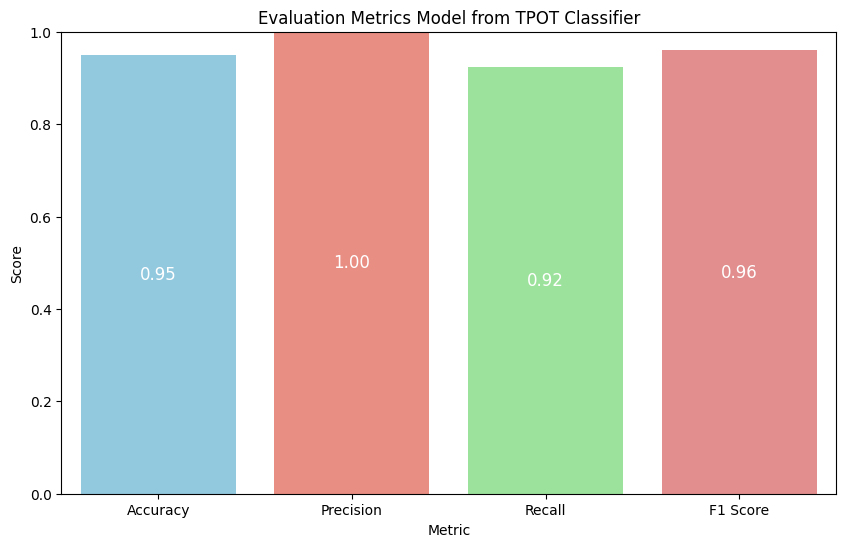

In [ ]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy_tpot, precision_tpot, recall_tpot, f1_tpot]
}
df = pd.DataFrame(data)
# Create a custom color palette
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral']
# Create a bar plot using Seaborn with a custom color palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=df, palette=colors)
plt.title('Evaluation Metrics Model from TPOT Classifier')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy, precision, recall, and F1 score
# Add annotations with the scores inside each bar
for index, value in enumerate(df['Score']):
    ax.text(index, value/2, f'{value:.2f}', ha='center', va='center', color='white', fontsize=12)
plt.show()


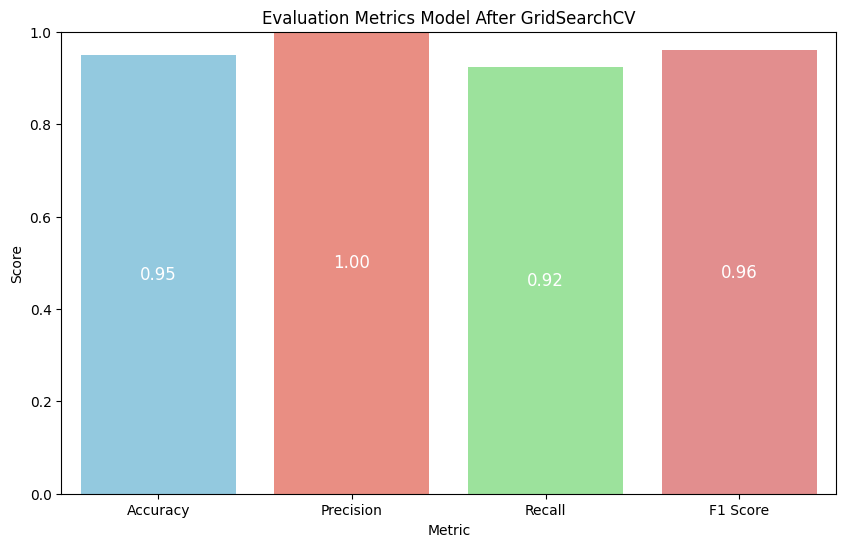

In [ ]:
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy_tuning, precision_tuning, recall_tuning, f1_tuning]
}
df = pd.DataFrame(data)
# Create a custom color palette
colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral']
# Create a bar plot using Seaborn with a custom color palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Score', data=df, palette=colors)
plt.title('Evaluation Metrics Model After GridSearchCV')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy, precision, recall, and F1 score
# Add annotations with the scores inside each bar
for index, value in enumerate(df['Score']):
    ax.text(index, value/2, f'{value:.2f}', ha='center', va='center', color='white', fontsize=12)
plt.show()
